In [5]:
pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 MB 5.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install torchvision 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.6 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [3]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [2]:
image_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229]),  # Grayscale normalization
    ]),
    'valid': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229]),  # Grayscale normalization
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229]),  # Grayscale normalization
    ])
}


In [3]:
dataset = '/Users/rishi/Downloads/CLASSIFICATION-OF-PNEUMONIA-USING-PRETRAINED-ALEXNET-MODEL-FROM-CHEST-X-RAY-IMAGES-DURING-COVID-19-main/Datasets/dataset_for_fourway_classification'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')

# Batch size
bs = 32

# Number of classes
num_classes = len(os.listdir(valid_directory))  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

6
{0: 'Bacterial Pneumonia', 1: 'COVID 19', 2: 'NORMAL', 3: 'Tuberculosis', 4: 'Viral Pneumonia'}


In [4]:
train_data_size, valid_data_size

(19559, 922)

In [5]:

class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5),  # Change input channels to 1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(4, 10, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(28090, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [6]:
lenet5 = LeNet5(num_classes)

# Define loss function and optimizer
loss_func = nn.NLLLoss()
optimizer = optim.Adam(lenet5.parameters())
lenet5

LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=28090, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=6, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [7]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [8]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 10
trained_model, history = train_and_validate(lenet5, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/10
Epoch : 001, Training: Loss: 0.7579, Accuracy: 67.8307%, 
		Validation : Loss : 1.2299, Accuracy: 24.7289%, Time: 187.0013s
Epoch: 2/10
Epoch : 002, Training: Loss: 0.6048, Accuracy: 74.1807%, 
		Validation : Loss : 0.9840, Accuracy: 38.1779%, Time: 181.2928s
Epoch: 3/10
Epoch : 003, Training: Loss: 0.5316, Accuracy: 77.7443%, 
		Validation : Loss : 0.9572, Accuracy: 38.8286%, Time: 172.6247s
Epoch: 4/10
Epoch : 004, Training: Loss: 0.4849, Accuracy: 79.2934%, 
		Validation : Loss : 1.2624, Accuracy: 31.7787%, Time: 173.4406s
Epoch: 5/10
Epoch : 005, Training: Loss: 0.4584, Accuracy: 80.6892%, 
		Validation : Loss : 0.8874, Accuracy: 45.9870%, Time: 173.6752s
Epoch: 6/10
Epoch : 006, Training: Loss: 0.4332, Accuracy: 81.8089%, 
		Validation : Loss : 0.8480, Accuracy: 49.8915%, Time: 174.7854s
Epoch: 7/10
Epoch : 007, Training: Loss: 0.4215, Accuracy: 82.5298%, 
		Validation : Loss : 0.6682, Accuracy: 62.9067%, Time: 173.3925s
Epoch: 8/10
Epoch : 008, Training: Loss: 0.4001,

In [11]:
y_true = []
y_pred = []

# Create a DataLoader for your validation dataset
validation_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)

# Assuming 'validation_dataset' is your validation dataset

# Iterate through the validation dataset and collect actual and predicted labels
for inputs, labels in validation_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass - compute outputs on input data using the model
    outputs = trained_model(inputs)

    # Calculate predictions
    _, predicted = torch.max(outputs, 1)

    # Append actual and predicted labels to y_true and y_pred
    y_true.extend(labels.cpu().numpy().tolist())
    y_pred.extend(predicted.cpu().numpy().tolist())

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 84.97%


In [ ]:
history.remove("avg_valid_loss","avg_valid_acc")
history

In [ ]:

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss',])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.tight_layout()
plt.show()

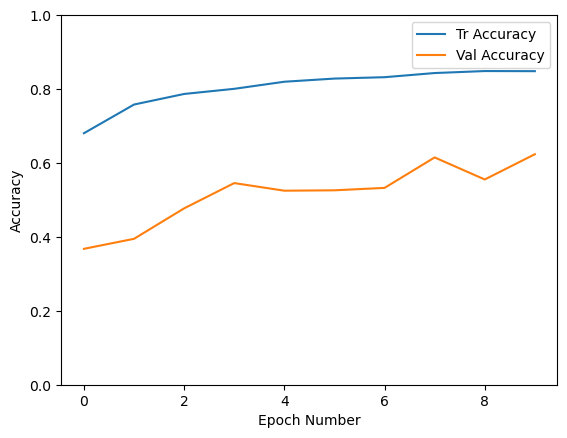

In [22]:
plt.plot(history[:,2:4])

plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

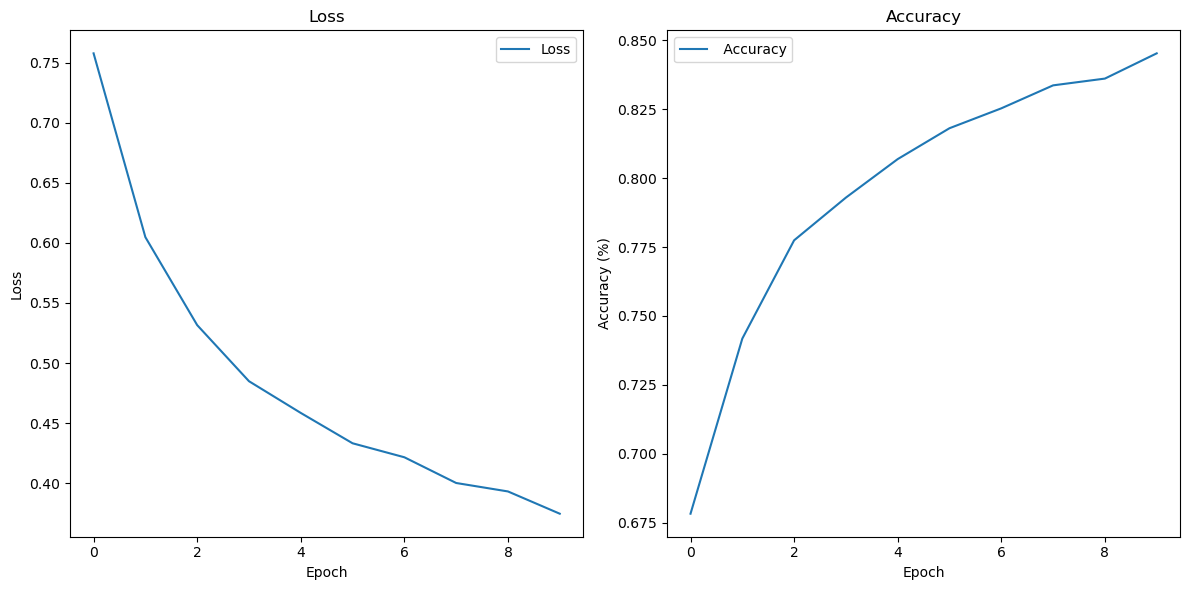

In [23]:
training_loss = [item[0] for item in history]
training_accuracy = [item[2] for item in history]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot training loss
ax1.plot(training_loss, label="Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.set_title("Loss")

# Plot training accuracy
ax2.plot(training_accuracy, label=" Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.legend()
ax2.set_title("Accuracy")

plt.tight_layout()
plt.show()